In [1]:

import torch 
import torch.nn as nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import cv2
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.0..213.0].


torch.Size([256, 256, 3])
torch.Size([1, 3, 256, 256])


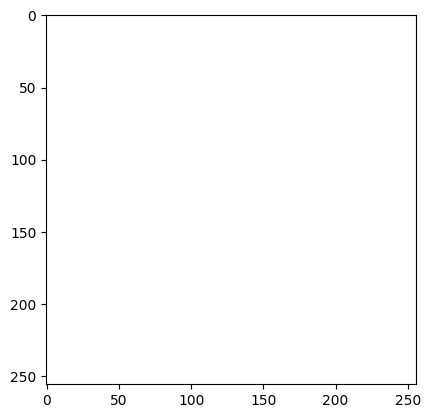

In [2]:
%matplotlib inline

input_image = cv2.imread('./test2.jpg')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = torch.tensor(input_image, dtype=torch.float32)
plt.imshow(input_image)
print(input_image.shape)
input_image = torch.permute(input_image, [2, 0, 1])
input_image = input_image.unsqueeze(0)
print(input_image.shape)

In [19]:
"""
# 1, 3, 256 = h p1, 256 = w p2
"""

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

class ViT(nn.Module):
    def __init__(self, 
                image_size=256,
                patch_size=32, 
                channels=3, 
                dim=1024, 
                dropout=0.1,
                *args, 
                **kwargs
    ):
        super().__init__(*args, **kwargs)
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        patch_dim = channels * patch_width * patch_height
        num_patches = (image_height//patch_height) * (image_width//patch_width)

        self.patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, dim)
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, img):
        # patch embedding
        x = self.patch_embedding(img)
        # cls token
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1) # 1, 65, 1024

        # position embedding
        x += self.pos_embedding[:, :(n+1)]

        x = self.dropout(x)
        
        # TODO - transformer encoder
            # TODO - multi-head attention
                # TODO - Scaled Dot Product Attention
        # TODO - MLP Head
        return x

model = ViT()
output = model(input_image)

torch.Size([1, 65, 1024])


In [16]:
t1 = torch.randn(1, 65, 124)
t2 = torch.randn(1, 65, 124)
t = t1 + t2
t

tensor([[[ 2.0134, -0.0488, -1.2662,  ..., -2.4665,  0.7635,  1.6184],
         [-0.6497, -2.8411, -0.7815,  ...,  0.9603,  1.3650, -1.4025],
         [-1.1170,  0.8083,  1.7266,  ..., -0.8189,  1.9447,  0.5346],
         ...,
         [-1.8371, -0.9222,  3.1988,  ...,  2.5397, -0.6392, -1.5621],
         [ 1.5189, -0.0195, -1.4579,  ...,  0.6716, -0.1916,  1.7458],
         [-0.3324, -1.1630, -0.5694,  ...,  0.4216,  0.3495, -0.1765]]])

torch.Size([1, 64, 1024])


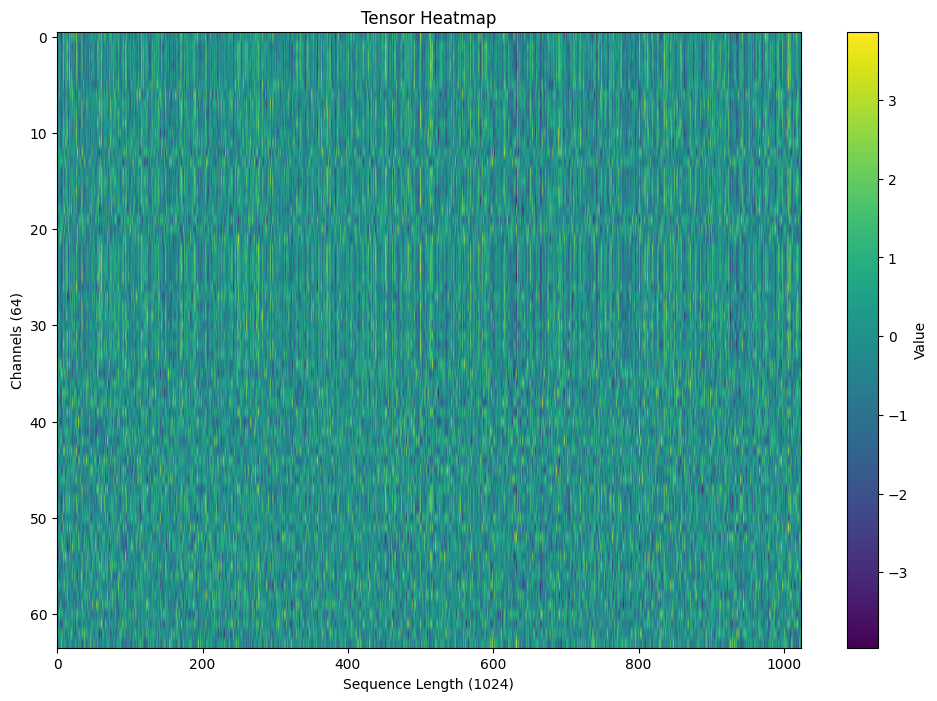

In [16]:
print(output.shape)
tensor_2d = output.squeeze(0).detach().numpy()  # Shape: (64, 1024)

# Plot as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(tensor_2d, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.xlabel('Sequence Length (1024)')
plt.ylabel('Channels (64)')
plt.title('Tensor Heatmap')
plt.show()